In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `hf auth whoami` to get more information or `hf auth logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The tok

In [3]:
!pip install datasets transformers accelerate

In [4]:
!pip install torch tensorflow evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00


In [ ]:
!apt install git-lfs

In [5]:
import torch
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset
import wandb
from transformers import AutoTokenizer
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score

In [6]:
!pip install kaggle

In [7]:
from datasets import load_dataset

# Charger le dataset AG News directement
dataset = load_dataset('ag_news')
data = dataset['train'].to_pandas()
test_data = dataset['test'].to_pandas()

print("✅ Dataset AG News chargé depuis Hugging Face!")
print(data.head())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

✅ Dataset AG News chargé depuis Hugging Face!
                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
3  Iraq Halts Oil Exports from Main Southern Pipe...      2
4  Oil prices soar to all-time record, posing new...      2


In [8]:
data.shape, test_data.shape

((120000, 2), (7600, 2))

In [9]:
data['label'].unique(), test_data['label'].unique()

(array([2, 3, 1, 0]), array([2, 3, 1, 0]))

In [10]:
data['label'].value_counts()

,count
label,
2,30000
3,30000
1,30000
0,30000


In [11]:
test_data['label'].value_counts()

,count
label,
2,1900
3,1900
1,1900
0,1900


In [ ]:
data.isnull().sum()

In [ ]:
data['text'][2]

"Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums."

In [12]:
slash = 0
slash_n = 0
douple_space = 0
for text in data['text']:
    if '\\' in text:
        slash+=1
    if '\n'in text:
        slash_n+=1
    if r'\s+' in text:
        douple_space+=1

print('\\ in ',slash, 'samples')
print('\\n in ',slash_n, 'samples')
print('douple space in ',douple_space, 'samples')

\ in  13146 samples
\n in  0 samples
douple space in  0 samples


In [14]:
test = test_data.copy()

In [15]:
test['label'].value_counts()

,count
label,
2,1900
3,1900
1,1900
0,1900


In [16]:
data['text'][1]

'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'

In [17]:
def clean(text):
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

In [18]:
data['text'] = data['text'].apply(lambda x: clean(x))
test['text'] = test['text'].apply(lambda x: clean(x))

data['text'][1]

'carlyle looks toward commercial aerospace reuters reuters private investment firm carlyle group which has a reputation for making well timed and occasionally controversial plays in the defense industry has quietly placed its bets on another part of the market '

In [19]:
# Convert Pandas DataFrame to HuggingFace Dataset
dataset = Dataset.from_pandas(data)
testing = Dataset.from_pandas(test)

In [20]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenization(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

encoded_dataset = dataset.map(tokenization, batched=True)
encoded_testing = testing.map(tokenization, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [21]:
# Remove old text columns, keep model inputs
encoded_dataset = encoded_dataset.rename_column('label', 'labels')
encoded_testing = encoded_testing.rename_column('label', 'labels')

encoded_dataset.set_format('torch')
encoded_testing.set_format('torch')

## ***Load model***

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Load pre-trained DistilBERT model for classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
model.to(device)

NameError: name 'DistilBertForSequenceClassification' is not defined

# ***Model training***

In [9]:
# Training arguments
training_args = TrainingArguments(
    output_dir="houssam77_distilbert_ag_news",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,             # tuning
    per_device_train_batch_size=32, # tuning
    per_device_eval_batch_size=32,  # tuning
    num_train_epochs=10,             # tuning
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy", # eval
    save_total_limit=1,
    logging_dir='./logs',
    logging_steps=50,
    fp16=True ,
    push_to_hub=True,
)

NameError: name 'TrainingArguments' is not defined

In [25]:
# Define evaluation metrics
def compute_metrics(pred):
    logits, labels = pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [26]:
from google.colab import files
import os
import json

# Upload du fichier kaggle.json
uploaded = files.upload()

# Créer le dossier .kaggle
!mkdir -p ~/.kaggle

# Copier le fichier au bon endroit
!cp kaggle.json ~/.kaggle/

# Donner les permissions appropriées
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Configuration Kaggle terminée!")

Saving kaggle.json to kaggle.json
✅ Configuration Kaggle terminée!


In [27]:
# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset,
    eval_dataset=encoded_testing,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
trainer.train()

/tmp/ipython-input-3374565413.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: houssamlefani (houssamlefani-coca-cola) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.199600,0.207564,0.934737,0.934900
2,0.145600,0.188056,0.942763,0.942772
3,0.098500,0.220884,0.939342,0.939249
4,0.062400,0.295336,0.934474,0.934582


TrainOutput(global_step=15000, training_loss=0.13627773888111114, metrics={'train_runtime': 5512.8768, 'train_samples_per_second': 217.672, 'train_steps_per_second': 6.802, 'total_flos': 6.358661922816e+16, 'train_loss': 0.13627773888111114, 'epoch': 4.0})

In [28]:
# Save final model
trainer.save_model("./houssam77_distilbert_ag_news")
tokenizer.save_pretrained("./houssam77_distilbert_ag_news")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...istilbert_ag_news/training_args.bin: 100%|##########| 5.78kB / 5.78kB            

  ...istilbert_ag_news/model.safetensors:  13%|#2        | 33.5MB /  268MB            

('./houssam77_distilbert_ag_news/tokenizer_config.json',
 './houssam77_distilbert_ag_news/special_tokens_map.json',
 './houssam77_distilbert_ag_news/vocab.txt',
 './houssam77_distilbert_ag_news/added_tokens.json',
 './houssam77_distilbert_ag_news/tokenizer.json')

In [29]:
results = trainer.evaluate()
print("Final Evaluation Results:", results)

Final Evaluation Results: {'eval_loss': 0.18805567920207977, 'eval_accuracy': 0.9427631578947369, 'eval_f1': 0.9427719495623853, 'eval_runtime': 27.7899, 'eval_samples_per_second': 273.481, 'eval_steps_per_second': 8.564, 'epoch': 4.0}


In [30]:
# Training logs
training_logs = trainer.state.log_history

# Extract training loss and validation accuracy
train_loss = [log["loss"] for log in training_logs if "loss" in log]
eval_acc = [log["eval_accuracy"] for log in training_logs if "eval_accuracy" in log]

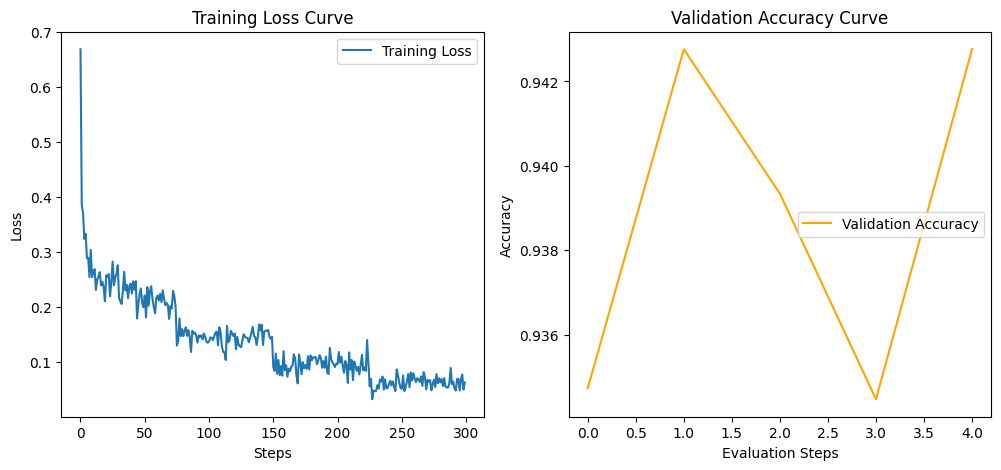

In [31]:
plt.figure(figsize=(12,5))

# Training Loss
plt.subplot(1,2,1)
plt.plot(train_loss, label="Training Loss")
plt.title("Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

# Validation Accuracy
plt.subplot(1,2,2)
plt.plot(eval_acc, label="Validation Accuracy", color='orange')
plt.title("Validation Accuracy Curve")
plt.xlabel("Evaluation Steps")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [5]:
def predict(texts):
    model.eval()
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=-1)
    return preds

In [16]:
import random
# Test random samples
sample_indices = random.sample(range(len(test_data)), 7)

# Create DataFrame
df_results = pd.DataFrame([
    {
        'sample_text': test_data['text'][i],
        'actual': test_data['label'][i]
    }
    for i in sample_indices
])
df_results['cleaned_text'] = df_results['sample_text'].apply(clean)

df_results['predicted'] = predict(df_results['cleaned_text'].tolist()).cpu().numpy()

print()

# Label mapping as provided
label_mapping = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}


# Define color codes
b = '\033[94m' #Blue
g = '\033[92m' #Green
r = '\033[0m' #Reset
B = '\033[1m' #Bold


for idx, row in df_results.iterrows():
    print(f"{B}Sample:{r} {row['sample_text']}")
    print(f"{B}{b}Predicted: {r}{label_mapping[row['predicted']]}  {g}{B}Actual: {r}{label_mapping[row['actual']]}\n")

print()


Sample: Civil servants in net porn probe More than 200 staff at the Department of Work and Pensions have been disciplined for downloading porn at work.
Predicted: Sci/Tech  Actual: Sci/Tech

Sample: Plus: Cendant reported to buy Ebookers SAN FRANCISCO (CBS.MW) -- Not only did the word  quot;blog quot; enter Merriam-Webster #39;s dictionary this year, but Microsoft is getting on the personalized e-journal bandwagon.
Predicted: Business  Actual: Sci/Tech

Sample: Yankees stay in tune Unbeaten Orlando Hernandez pitched seven innings of five-hit ball to win his eighth straight decision, and the New York Yankees beat Sidney Ponson and the Orioles, 5-2, yesterday in Baltimore.
Predicted: Sports  Actual: Sports

Sample: Intel gets off chip speed roller coaster: Technology India: New York, Oct 19 : The world #39;s leading computer chipmaker Intel has jumped off the chip speed roller coaster by yanking its four giga hertz (4 GHz) Pentium 4 processor off the drawing board.
Predicted: Sci/Tech  

# ***Testing my model***

In [31]:
import random
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re

# Fonction de nettoyage du texte
def clean(text):
    # Supprimer les caractères spéciaux et les chiffres
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convertir en minuscules
    text = text.lower()
    # Supprimer les espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Charger votre modèle et tokenizer pré-entraînés
model_path = "houssam2030/houssam77_distilbert_ag_news"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Mettre le modèle en mode évaluation
model.eval()

# Fonction de prédiction
def predict(texts):
    # Tokeniser les textes
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )

    # Faire la prédiction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)

    return predictions


# Charger les données de test AG News
from datasets import load_dataset
dataset = load_dataset('ag_news')
test_data = dataset['test'].to_pandas()

# Mapping des labels AG News
label_mapping = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# Test sur des échantillons aléatoires
sample_indices = random.sample(range(len(test_data)), 5)

# Créer DataFrame avec les échantillons
df_results = pd.DataFrame([
    {
        'sample_text': test_data['text'][i],
        'actual': test_data['label'][i]
    }
    for i in sample_indices
])

# Nettoyer le texte
df_results['cleaned_text'] = df_results['sample_text'].apply(clean)

# Faire les prédictions
df_results['predicted'] = predict(df_results['cleaned_text'].tolist()).cpu().numpy()

print("🔍 Résultats des prédictions sur AG News:\n")

# Définir les codes couleur
b = '\033[94m'  # Blue
g = '\033[92m'  # Green
r = '\033[0m'   # Reset
B = '\033[1m'   # Bold

# Afficher les résultats
correct = 0
total = len(df_results)

for idx, row in df_results.iterrows():
    predicted_label = label_mapping[row['predicted']]
    actual_label = label_mapping[row['actual']]

    is_correct = predicted_label == actual_label
    if is_correct:
        correct += 1

    color = g if is_correct else b

    print(f"{B}Sample {idx+1}:{r} {row['sample_text'][:100]}...")
    print(f"{B}Predicted: {color}{predicted_label}{r}")
    print(f"{B}Actual: {g}{actual_label}{r}")
    print(f"{B}Correct: {color}{is_correct}{r}")
    print("-" * 80 + "\n")

# Calculer la précision
accuracy = correct / total * 100
print(f"{B}🎯 Précision sur {total} échantillons: {g}{accuracy:.2f}%{r}")


🔍 Résultats des prédictions sur AG News:

Sample 1: Amputation rate for US troops twice that of past wars US troops injured in Iraq have required limb a...
Predicted: World
Actual: World
Correct: True
--------------------------------------------------------------------------------

Sample 2: Waugh: Shoaib will test Australians Former Australian skipper Steve Waugh says he thinks Shoaib Akht...
Predicted: Sports
Actual: Sports
Correct: True
--------------------------------------------------------------------------------

Sample 3: Tribe challenges American origins Some of the earliest settlers of America may have been from Austra...
Predicted: Sci/Tech
Actual: Sci/Tech
Correct: True
--------------------------------------------------------------------------------

Sample 4: Knicks Hold Off Raptors, 108-102 New York Knicks #39; Jamal Crawford puts up a shot against the Toro...
Predicted: Sports
Actual: Sports
Correct: True
------------------------------------------------------------------

In [ ]:
# Optionnel: Test sur tout le dataset (attention: peut être long)
def evaluate_on_full_dataset(sample_size=100):
    """Évaluation sur un sous-ensemble du dataset"""
    print(f"\n{B}📊 Évaluation sur {sample_size} échantillons...{r}")

    # Prendre un échantillon aléatoire
    sample_indices = random.sample(range(len(test_data)), sample_size)
    sample_texts = test_data['text'].iloc[sample_indices].tolist()
    sample_labels = test_data['label'].iloc[sample_indices].tolist()

    # Nettoyer et prédire
    cleaned_texts = [clean(text) for text in sample_texts]
    predictions = predict(cleaned_texts).cpu().numpy()

    # Calculer la précision
    correct = sum(1 for pred, actual in zip(predictions, sample_labels) if pred == actual)
    accuracy = correct / sample_size * 100

    print(f"{B}Précision sur {sample_size} échantillons: {g}{accuracy:.2f}%{r}")
    return accuracy

# Décommenter pour évaluer sur plus d'échantillons
# evaluate_on_full_dataset(100)

In [27]:
from transformers import AutoModelForSequenceClassification, pipeline
import time

# Charger un modèle plus grand (ex: BERT-base)
llm_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
my_model = AutoModelForSequenceClassification.from_pretrained("houssam2030/houssam77_distilbert_ag_news")

# Créer un pipeline pour les deux modèles
slm_pipeline = pipeline("text-classification", model=my_model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)
llm_pipeline = pipeline("text-classification", model=llm_model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Device set to use cpu


In [ ]:
import psutil
import torch

def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024  # MB

# Mémoire avant chargement
mem_before = get_memory_usage()

# Charger le modèle
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=num_labels)

# Mémoire après chargement
mem_after = get_memory_usage()
print(f"Mémoire utilisée: {mem_after - mem_before:.2f} MB")

In [ ]:
import time

def benchmark_inference(model, tokenizer, texts, repetitions=10):
    model.eval()
    times = []

    with torch.no_grad():
        for _ in range(repetitions):
            start_time = time.time()

            inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
            outputs = model(**inputs)

            end_time = time.time()
            times.append(end_time - start_time)

    return np.mean(times), np.std(times)

# Benchmark
sample_texts = dataset["test"]["text"][:10]  # 10 échantillons pour le test
mean_time, std_time = benchmark_inference(model, tokenizer, sample_texts)
print(f"Temps d'inférence moyen: {mean_time:.4f}s ± {std_time:.4f}s")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Créer un DataFrame pour les résultats
results = pd.DataFrame({
    "Modèle": ["SLM (DistilBERT)", "LLM (BERT-base)"],
    "Accuracy": [slm_accuracy, llm_accuracy],
    "Temps Inférence (s)": [slm_time, llm_time],
    "Mémoire (MB)": [mem_usage, mem_after]
})

print(results)

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

results.plot(x="Modèle", y="Accuracy", kind="bar", ax=axes[0], title="Accuracy")
results.plot(x="Modèle", y="Temps Inférence (s)", kind="bar", ax=axes[1], title="Temps d'Inférence")
results.plot(x="Modèle", y="Mémoire (MB)", kind="bar", ax=axes[2], title="Occupation Mémoire")

plt.tight_layout()
plt.savefig("comparaison_slm_vs_llm.png")
plt.show()